In [3]:
def anomaly_skill(df):
    """
    Performs comprehensive anomaly detection on DataFrame.

    Function Description:
    Analyzes DataFrame for various types of anomalies including:
    1. Missing values
    2. Duplicate rows
    3. Numerical outliers
    4. Timestamp patterns
    5. Rare categorical values
    6. Error patterns in text

    Input:
    - df (pd.DataFrame): DataFrame to analyze

    Output:
    - str: Path to generated PNG file containing anomaly report

    Note:
    - Returns empty DataFrame if no anomalies found
    - Saves visualization even if no anomalies detected
    """
    print('[INFO] Anomaly Skill called')
    import numpy as np
    from scipy import stats
    import pandas as pd
    from tabulate import tabulate
    import matplotlib.pyplot as plt
    from datetime import datetime
    log_df = df
    anomalies = {}

    #########################
    ### 0. Number of rows ###
    #########################
    anomalies['Number of rows'] = len(log_df)

    ###########################################
    ### 1. Check for missing or null values ###
    ###########################################
    missing_values = pd.DataFrame(log_df.isnull().sum()).reset_index()
    missing_values.columns = ['Column', 'NA Count']
    missing_values = missing_values[missing_values['NA Count'] > 0]
    anomalies['missing_values'] = tabulate(missing_values, headers=missing_values.columns, tablefmt='pretty', showindex=False) if missing_values.shape[0] > 0 else 'No missing values'
    print('[INFO] Anomaly Skill: missing values checked')

    ################################
    ### 2. Detect duplicate rows ###
    ################################
    duplicate_rows = log_df[log_df.duplicated()]
    anomalies['duplicate_rows'] = len(duplicate_rows)
    print('[INFO] Anomaly Skill: duplicate rows checked')

    ##############################################
    ### 3. Identify and handle numeric columns ###
    ##############################################
    numeric_columns = log_df.select_dtypes(include=[np.number]).columns
    numeric_columns = numeric_columns[~numeric_columns.str.contains('id|index', case=False)]

    if not numeric_columns.empty:
        outliers_data = []

        for column in numeric_columns:
            try:
                temp = log_df[column].dropna().sort_values()
                if len(temp) == 0:
                    continue
                comp = list(range(len(temp)))
                correlation = np.corrcoef(comp, temp)[0, 1]
                
                # If the correlation is close to 1, skip outlier detection for this column
                
                if np.abs(correlation) > 0.95 or np.isnan(correlation):  # Threshold to decide if it's linear
                    continue

                Q1 = log_df[column].quantile(0.25)
                Q3 = log_df[column].quantile(0.75)
                
                IQR = Q3 - Q1
    
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers_in_column = log_df[(log_df[column] < lower_bound) | (log_df[column] > upper_bound)]
            
                outliers_in_column['distance_from_bound'] = outliers_in_column[column].apply(
                    lambda x: lower_bound - x if x < lower_bound else x - upper_bound
                )
                
                outliers_sorted = outliers_in_column.sort_values(by='distance_from_bound', ascending=False)
                
                # Select the top 3 most extreme outliers for the column
                top_3_outliers = outliers_sorted.head(3)
                
                # 11. Append the top 3 outliers for this column to the list (row number, column, value, distance)
                for index, row in top_3_outliers.iterrows():
                    outliers_data.append({
                        'numeric_column': column,
                        'row_number': index,
                        'outlier_value': row[column]
                    })
            except Exception as err:
                print(err)

        if outliers_data:
            outliers_df = pd.DataFrame(outliers_data)
        else:
            outliers_df = pd.DataFrame(columns=['numeric_column', 'row_number', 'outlier_value'])
        
        anomalies['numeric_outliers'] = tabulate(outliers_df, headers=outliers_df.columns, tablefmt='pretty', showindex=False) if not outliers_df.empty else 'No numerical anomalies'
    print('[INFO] Anomaly Skill: numerical outliers checked')

    ##################################
    ### 4. Infer timestamp columns ###
    ##################################
    timestamp_columns = []
    for col in log_df.columns:
        try:
            if 'date' in col.lower() or 'time' in col.lower(): 
                timestamp_columns.append(col)
        except Exception:
            continue

    def timing_resampler(df, interval, column):
        """
        Resamples time series data at specified intervals.

        Function Description:
        Groups data by time intervals and calculates statistical measures (skewness, kurtosis)
        to identify unusual patterns in temporal distribution.

        Input:
        - df (pd.DataFrame): DataFrame containing timestamp data
        - interval (str): Time interval for resampling (e.g., '1min', '1H')
        - column (str): Name of timestamp column

        Output:
        - tuple: Contains:
            - interval_df: Resampled DataFrame
            - skew: Skewness measure
            - kurt: Kurtosis measure
            - total: Combined statistical measure

        Note:
        - Returns empty DataFrame if resampling fails
        - Requires datetime-formatted column
        """
        interval_counts = df.resample(interval, on=column).size()
        interval_df = pd.DataFrame(interval_counts).reset_index()
        interval_df.columns = [f'Interval_{interval}', 'Count']
        skew = interval_df['Count'].skew()
        kurt = interval_df['Count'].kurt()
        return (interval_df, skew, kurt, skew+ np.abs(kurt-3))

    def timing_outliers(interval_df):
        """
        Identifies temporal outliers using IQR method.

        Function Description:
        Calculates outlier bounds using interquartile range and filters
        data points that fall outside these bounds.

        Input:
        - interval_df (pd.DataFrame): DataFrame with count data by interval

        Output:
        - filtered_df (pd.DataFrame): DataFrame containing only outlier points

        Note:
        - Returns empty DataFrame if no outliers found
        - Uses 1.5 * IQR as outlier threshold
        """
        q1 = interval_df['Count'].quantile(0.25)
        q3 = interval_df['Count'].quantile(0.75)
        iqr = q3-q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        filtered_df = interval_df[(interval_df['Count'] > upper) | (interval_df['Count'] < lower)].reset_index(drop=True)
        return filtered_df

    def best_timing(df, ts_col):
        """
        Determines optimal time interval for anomaly detection.

        Function Description:
        Tests multiple time intervals and selects the one that produces
        the most meaningful anomaly pattern based on statistical measures.

        Input:
        - df (pd.DataFrame): Input DataFrame
        - ts_col (str): Name of timestamp column

        Output:
        - tuple: Contains:
            - best_interval (str): Optimal sampling interval
            - best_df (pd.DataFrame): Outliers at optimal interval

        Note:
        - Returns ('NA', empty DataFrame) if no valid intervals found
        - Tests intervals from 1 minute to 1 day
        """
        intervals = ['1min', '5min', '10min', '30min', '1H', '2H', '3H', '6H', '12H', '1D']
        res = []
        for i in intervals:
            data, skew, kurt, total = timing_resampler(df, i , ts_col)
            if len(data) == 0:
                pass
            res.append((i, data, skew, kurt, total))

        if len(res) == 0:
            return 'NA', pd.DataFrame()

        res.sort(key=lambda x:x[-1])
        best_interval = res[0][0]
        best_df = timing_outliers(res[0][1])
        return best_interval, best_df

    if timestamp_columns:
        for ts_col in timestamp_columns:
            try:
                log_df[ts_col] = pd.to_datetime(log_df[ts_col], errors='coerce')
                interval, data = best_timing(log_df, ts_col)
                if len(data) != 0 and interval != 'NA':
                    data = data.sort_values(by='Count', ascending=False)
                    anomalies[f'timestamp_freq_anomaly_{ts_col}_{interval}'] = tabulate(data, headers=data.columns, tablefmt='pretty', showindex=False)
            except Exception as err:
                print(err)
                
    print('[INFO] Anomaly Skill: timestamp checked')

    ##################################################################
    ### 5. Identify categorical columns and detect rare categories ###
    ##################################################################
    categorical_columns = log_df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        try:
            event_frequency = log_df[col].value_counts()
            event_frequency_df = pd.DataFrame(event_frequency).reset_index()
            if len(event_frequency_df) <= 10:
                continue
            event_frequency_df.columns = ['Value', 'Count']
            event_frequency_df = event_frequency_df.sort_values('Count', ascending=True)
            rarest = event_frequency_df.head(3)
            rarest['Value'] = rarest['Value'].apply(lambda x: x[:200])
            anomalies[f'Rare_values_in_{col}'] = tabulate(rarest, headers=rarest.columns, tablefmt='pretty', showindex=False)
        except Exception as err:
            print(err)

    print('[INFO] Anomaly Skill: categorical columns checked')

    #################################
    ### 6. Identify error columns ###
    #################################
    non_numeric_columns = log_df.select_dtypes(include=['object']).columns
    error_results = []

    for column in non_numeric_columns:
        try:
            anomaly = log_df[log_df[column].str.contains('anomaly|anomalies', case=False, na=False)]
            anomaly_count = len(anomaly)
            error = log_df[log_df[column].str.contains('error|errors', case=False, na=False)]
            error_count = len(error)
            warning = log_df[log_df[column].str.contains('warning|warn', case=False, na=False)]
            warning_count = len(warning)
            res = [('anomalies',anomaly_count), ('errors', error_count), ('warnings', warning_count)]
            res_dic = {}
            for check, count in res:
                if count > 0:
                    res_dic[check] = count
            if len(res_dic) > 0:
                error_results.append((column, str(res_dic)))
        except Exception as err:
            print(err)

    if len(error_results) > 0:
        error_results_df = tabulate(error_results, headers=['Column', 'Error Counts'], tablefmt='grid')
        anomalies['Error Checks'] = error_results_df

    ##################
    ### Disclaimer ###
    ##################
    anomalies['DISCLAIMER'] = "1. For a detailed overview on the rare categories in each column, please query for a summary of the data and refer to the SweetVIZ summary. \n2. For rare categories, some values may be cut off if it is too long."

    ########################
    ### add in timestamp ###
    ########################
    anomalies['ANOMALY CHECK DATE'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    ##################################
    ### Ploting and returning path ###
    ##################################
    anomaly_table = [(key, str(value)) for key, value in anomalies.items()]
    anomaly_table = tabulate(anomaly_table, headers=['Check', 'Details'], tablefmt='grid')

    fig, ax = plt.subplots(figsize=(8, 4))  
    ax.axis('off')  
    plt.text(0.5, 0.5, anomaly_table, family='monospace', ha='center', va='center', fontsize=12)


    png_path = "tabulated_anomalies.png"
    plt.savefig(png_path, bbox_inches='tight', dpi=300)

    return png_path

In [ ]:
def overall_anomaly(df) -> str:
    """
    Performs comprehensive anomaly detection on DataFrame.

    Function Description:
    Analyzes DataFrame for various types of anomalies including:
    1. Missing values
    2. Duplicate rows
    3. Numerical outliers
    4. Timestamp patterns
    5. Rare categorical values
    6. Error patterns in text

    Input:
    - df (pd.DataFrame): DataFrame to analyze

    Output:
    - str: Path to generated PNG file containing anomaly report

    Note:
    - Returns empty DataFrame if no anomalies found
    - Saves visualization even if no anomalies detected
    """
    print('[INFO] Anomaly Skill called')
    import numpy as np
    from scipy import stats
    import pandas as pd
    from tabulate import tabulate
    import matplotlib.pyplot as plt
    from datetime import datetime
    from copy import deepcopy
    log_df = df
    anomalies = {}

    #########################
    ### 0. Number of rows ###
    #########################
    anomalies['Number of rows'] = len(log_df)

    ###########################################
    ### 1. Check for missing or null values ###
    ###########################################
    missing_values = pd.DataFrame(log_df.isnull().sum()).reset_index()
    missing_values.columns = ['Column', 'NA Count']
    missing_values = missing_values[missing_values['NA Count'] > 0]
    anomalies['missing_values'] = tabulate(missing_values, headers=missing_values.columns, tablefmt='pretty', showindex=False) if missing_values.shape[0] > 0 else 'No missing values'
    print('[INFO] Anomaly Skill: missing values checked')

    ################################
    ### 2. Detect duplicate rows ###
    ################################
    duplicate_rows = log_df[log_df.duplicated()]
    anomalies['duplicate_rows'] = len(duplicate_rows)
    print('[INFO] Anomaly Skill: duplicate rows checked')

    ##############################################
    ### 3. Identify and handle numeric columns ###
    ##############################################
    numeric_columns = log_df.select_dtypes(include=[np.number]).columns
    numeric_columns = numeric_columns[~numeric_columns.str.contains('id|index', case=False)]

    if not numeric_columns.empty:
        outliers_data = []

        for column in numeric_columns:
            try:
                temp = log_df[column].dropna().sort_values()
                if len(temp) == 0:
                    continue
                comp = list(range(len(temp)))
                correlation = np.corrcoef(comp, temp)[0, 1]
                
                # If the correlation is close to 1, skip outlier detection for this column
                
                if np.abs(correlation) > 0.95 or np.isnan(correlation):  # Threshold to decide if it's linear
                    continue

                Q1 = log_df[column].quantile(0.25)
                Q3 = log_df[column].quantile(0.75)
                
                IQR = Q3 - Q1
    
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers_in_column = log_df[(log_df[column] < lower_bound) | (log_df[column] > upper_bound)]
            
                outliers_in_column['distance_from_bound'] = outliers_in_column[column].apply(
                    lambda x: lower_bound - x if x < lower_bound else x - upper_bound
                )
                
                outliers_sorted = outliers_in_column.sort_values(by='distance_from_bound', ascending=False)
                
                # Select the top 3 most extreme outliers for the column
                top_3_outliers = outliers_sorted.head(3)
                

                for index, row in top_3_outliers.iterrows():
                    outliers_data.append({
                        'numeric_column': column,
                        'row_number': index,
                        'outlier_value': row[column]
                    })
            except Exception as err:
                print(err)

        if outliers_data:
            outliers_df = pd.DataFrame(outliers_data)
        else:
            outliers_df = pd.DataFrame(columns=['numeric_column', 'row_number', 'outlier_value'])
        
        anomalies['numeric_outliers'] = tabulate(outliers_df, headers=outliers_df.columns, tablefmt='pretty', showindex=False) if not outliers_df.empty else 'No numerical anomalies'
    print('[INFO] Anomaly Skill: numerical outliers checked')

    ##################################
    ### 4. Infer timestamp columns ###
    ##################################
    timestamp_columns = []
    for col in log_df.columns:
        try:
            if 'date' in col.lower() or 'time' in col.lower(): 
                timestamp_columns.append(col)
        except Exception:
            continue

    def timing_resampler(df, interval, column):
        """
        Resamples time series data at specified intervals.

        Function Description:
        Groups data by time intervals and calculates statistical measures (skewness, kurtosis)
        to identify unusual patterns in temporal distribution.

        Input:
        - df (pd.DataFrame): DataFrame containing timestamp data
        - interval (str): Time interval for resampling (e.g., '1min', '1H')
        - column (str): Name of timestamp column

        Output:
        - tuple: Contains:
            - interval_df: Resampled DataFrame
            - skew: Skewness measure
            - kurt: Kurtosis measure
            - total: Combined statistical measure

        Note:
        - Returns empty DataFrame if resampling fails
        - Requires datetime-formatted column
        """
        interval_counts = df.resample(interval, on=column).size()
        interval_df = pd.DataFrame(interval_counts).reset_index()
        interval_df.columns = [f'Interval_{interval}', 'Count']
        interval_df = interval_df.sort_values(by='Count')
        return interval_df

    def timing_outliers(interval_df):
        """
        Identifies temporal outliers using IQR method.

        Function Description:
        Calculates outlier bounds using interquartile range and filters
        data points that fall outside these bounds.

        Input:
        - interval_df (pd.DataFrame): DataFrame with count data by interval

        Output:
        - filtered_df (pd.DataFrame): DataFrame containing only outlier points

        Note:
        - Returns empty DataFrame if no outliers found
        - Uses 1.5 * IQR as outlier threshold
        """
        q1 = interval_df['Count'].quantile(0.25)
        q3 = interval_df['Count'].quantile(0.75)
        iqr = q3-q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        filtered_df = interval_df[(interval_df['Count'] > upper) | (interval_df['Count'] < lower)].reset_index(drop=True)
        return filtered_df

    intervals = ['5min', '1H', '1D']
    if timestamp_columns:
        for ts_col in timestamp_columns:
            for i in intervals:
                try:
                    log_df[ts_col] = pd.to_datetime(log_df[ts_col], errors='coerce')
                    log_df_resampled = timing_resampler(log_df, i, ts_col)
                    outliers = timing_outliers(log_df_resampled)
                    if i == '1D':
                        print(log_df_resampled)
                    if len(outliers) != 0:
                        outliers = outliers.sort_values(by='Count', ascending=False)
                        outliers = outliers.head(3)
                        anomalies[f'timestamp_freq_anomaly_{ts_col}_{i}'] = tabulate(outliers, headers=outliers.columns, tablefmt='pretty', showindex=False)
                except Exception as err:
                    print(err)
                
    print('[INFO] Anomaly Skill: timestamp checked')

    ##################################################################
    ### 5. Identify categorical columns and detect rare categories ###
    ##################################################################
    categorical_columns = log_df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        try:
            event_frequency = log_df[col].value_counts()
            event_frequency_df = pd.DataFrame(event_frequency).reset_index()
            if len(event_frequency_df) <= 10:
                continue
            event_frequency_df.columns = ['Value', 'Count']
            event_frequency_df = event_frequency_df.sort_values('Count', ascending=True)
            rarest = event_frequency_df.head(3)
            rarest['Value'] = rarest['Value'].apply(lambda x: x[:200])
            anomalies[f'Rare_values_in_{col}'] = tabulate(rarest, headers=rarest.columns, tablefmt='pretty', showindex=False)
        except Exception as err:
            print(err)

    print('[INFO] Anomaly Skill: categorical columns checked')

    #################################
    ### 6. Identify error columns ###
    #################################
    non_numeric_columns = log_df.select_dtypes(include=['object']).columns
    error_results = []

    for column in non_numeric_columns:
        try:
            anomaly = log_df[log_df[column].str.contains('anomaly|anomalies', case=False, na=False)]
            anomaly_count = len(anomaly)
            error = log_df[log_df[column].str.contains('error|errors', case=False, na=False)]
            error_count = len(error)
            warning = log_df[log_df[column].str.contains('warning|warn', case=False, na=False)]
            warning_count = len(warning)
            res = [('anomalies',anomaly_count), ('errors', error_count), ('warnings', warning_count)]
            res_dic = {}
            for check, count in res:
                if count > 0:
                    res_dic[check] = count
            if len(res_dic) > 0:
                error_results.append((column, str(res_dic)))
        except Exception as err:
            print(err)

    if len(error_results) > 0:
        error_results_df = tabulate(error_results, headers=['Column', 'Error Counts'], tablefmt='grid')
        anomalies['Error Checks'] = error_results_df

    ##################
    ### Disclaimer ###
    ##################
    anomalies['DISCLAIMER'] = "1. For a detailed overview on the rare categories in each column, please query for a summary of the data and refer to the SweetVIZ summary. \n2. For rare categories, some values may be cut off if it is too long."

    ########################
    ### add in timestamp ###
    ########################
    anomalies['ANOMALY CHECK DATE'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    ##################################
    ### Ploting and returning path ###
    ##################################
    anomaly_table = [(key, str(value)) for key, value in anomalies.items()]
    anomaly_table = tabulate(anomaly_table, headers=['Check', 'Details'], tablefmt='grid')

    fig, ax = plt.subplots(figsize=(8, 4))  
    ax.axis('off')  
    plt.text(0.5, 0.5, anomaly_table, family='monospace', ha='center', va='center', fontsize=12)

    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as f:
        tempfile_path = f.name
        plt.savefig(tempfile_path, bbox_inches='tight', dpi=300)
        
    return tempfile_path

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import yaml
from tabulate import tabulate

df_mac = pd.read_csv('../../../logs/Windows/Windows_2k.log_structured.csv')
df_mac_anomaly = anomaly_skill(df_mac)
df_mac_anomaly_table = [(key, str(value)) for key, value in df_mac_anomaly.items()]
mac_table = tabulate(df_mac_anomaly_table, headers=['Check', 'Details'], tablefmt='grid')

In [9]:
import pandas as pd
import datetime
import re

def break_down_date_component(date_str):
    """
    Parses a date string and returns its components (year, month, day) based on various formats.

    Function Description:
    This function is designed to parse and extract components (year, month, day) from a string
    representing a date in various formats. The function handles:
      - Full dates (e.g., "2007-08-11").
      - Single-day representations (e.g., "11").
      - Month abbreviation with day (e.g., "Aug 11").
      - Day followed by month abbreviation (e.g., "11 Aug").
      - Month-only representations (e.g., "Jul" or "July").
    
    The function first tries to convert the input string into a datetime object.
    If that fails, it uses regular expressions to handle other date-like formats.

    Input:
    - date_str (str): A string representing a date or a part of a date in various formats.
    
    Output:
    - dict: A dictionary containing the following keys if the date components are parsed successfully:
        - 'year' (int): The year component of the date.
        - 'month' (int): The month component of the date (1-12).
        - 'day' (int): The day component of the date (1-31).
    - None: If the input doesn't match any recognizable date format.
    """

    # Try to convert it to a datetime object first (handles full dates like '2007-08-11')
    try:
        full_date = pd.to_datetime(date_str, errors='raise')
        return {
            'year': full_date.year,
            'month': full_date.month,
            'day': full_date.day
        }
    except (ValueError, TypeError):
        pass

    # Check if it's just a day (a single digit or two digits)
    if re.match(r'^\d{1,2}$', date_str):
        return {'day': int(date_str)}

    # Check if it's a month abbreviation and a day (e.g., "Aug 11")
    month_day_match = re.match(r'^([A-Za-z]+)\s+(\d{1,2})$', date_str)
    if month_day_match:
        month_str = month_day_match.group(1)
        day = int(month_day_match.group(2))
        month = pd.to_datetime(month_str, format='%b', errors='coerce').month
        return {'month': month, 'day': day}

    # Check if it's a day followed by a month (e.g., "11 Aug")
    day_month_match = re.match(r'^(\d{1,2})\s+([A-Za-z]+)$', date_str)
    if day_month_match:
        day = int(day_month_match.group(1))
        month_str = day_month_match.group(2)
        month = pd.to_datetime(month_str, format='%b', errors='coerce').month
        return {'month': month, 'day': day}
    
    # Check if the date_str is just a month (either abbreviation like 'Jul' or full name like 'July')
    month_match = re.match(r'^([A-Za-z]+)$', date_str)
    if month_match:
        month_str = month_match.group(1)
        month = pd.to_datetime(month_str, format='%b', errors='coerce').month
        
        if pd.isna(month):  # If it's not a valid abbreviated month, try full month name
            month = pd.to_datetime(month_str, format='%B', errors='coerce').month
        
        if month:  # Return only the month if matched
            return {'month': month}

    # If no match, return None or raise an error
    return None

def combine_datetime_columns(df, default_year=datetime.datetime.now().year):
    """
    Combines datetime-related components in a DataFrame into a single 'Datetime' column.

    Function Description:
    This function identifies columns in a DataFrame that contain datetime-related information 
    (e.g., year, month, day, time) and combines them into a single 'Datetime' column. 
    It also attempts to handle partial date components from a "Date" column, using the 
    `break_down_date_component` function to extract year, month, and day. If any of these 
    components are missing, a default year can be provided. The combined 'Datetime' column 
    is converted into a proper datetime object. The original datetime-related columns are 
    dropped from the DataFrame after successful conversion.

    Input:
    - df (pandas.DataFrame): A DataFrame containing date-related columns (e.g., year, month, day, etc.).
    - default_year (int, optional): A default year to use if the year component is missing. Defaults to the current year.

    Output:
    - df (pandas.DataFrame): The modified DataFrame with a 'Datetime' column containing the 
      combined datetime information. Original datetime-related columns are removed.
    
    Note:
    - If no datetime-related columns are found, the function returns the DataFrame as is.
    - If the conversion to a datetime object fails, an error message is printed.
    """

    # Define a list of common datetime-related column names
    datetime_keywords = ["year", "month", "day", "date", "time", "hour", "minute", "second"]

    # Identify columns that likely contain datetime information
    datetime_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in datetime_keywords)]
    
    if not datetime_cols:
        print("No datetime components found.")
        return df

    #keep copy of the original df to return in case conversion fails
    df_orig = df.copy()

    # Check if "Date" column already contains full or partial date components
    for col in df.columns:
        if 'date' in col.lower():
            # Attempt to break down the 'Date' column
            df[col] = df[col].astype(str)
            date_parts = df[col].apply(break_down_date_component)
            df['Year'] = [date.get('year', default_year) for date in date_parts]
            df['Month'] = df["Month"] if "Month" in df.columns else [date.get('month', None) for date in date_parts]
            df['Day'] = df["Day"] if "Day" in df.columns else [date.get('day', None) for date in date_parts]

            # Now combine the components into the 'Datetime' column
            if 'Time' in df.columns:
                df['Datetime'] = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str) + ' ' + df['Time'].astype(str)
            else:
                df['Datetime'] = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str)

            if "Year" not in datetime_cols:
                datetime_cols.append("Year")
            if "Month" not in datetime_cols:
                datetime_cols.append("Month")
            if "Day" not in datetime_cols:
                datetime_cols.append("Day")

    # Convert the combined "Datetime" column into a proper datetime format
    try:
        df['Datetime'] = pd.to_datetime(df['Datetime'])
        # Drop the original datetime-related columns after successful conversion
        cols_to_drop = datetime_cols
        if 'Datetime' in cols_to_drop:
            cols_to_drop.remove('Datetime')
        df.drop(columns=cols_to_drop, inplace=True)
        return df
    except Exception as e:
        print(f"Error converting to datetime, please check the format of the combined column: {e}")

    return df_orig


In [84]:
import pandas as pd

data = pd.read_csv('../../../logs/Mac/Mac_2k.log_structured.csv')

data = combine_datetime_columns(data, default_year=datetime.datetime.now().year)

[INFO] Anomaly Skill called
[INFO] Anomaly Skill: missing values checked
[INFO] Anomaly Skill: duplicate rows checked
[INFO] Anomaly Skill: numerical outliers checked
  Interval_1D  Count
7  2024-07-08     88
1  2024-07-02    140
4  2024-07-05    212
0  2024-07-01    216
5  2024-07-06    237
6  2024-07-07    325
2  2024-07-03    358
3  2024-07-04    424
[INFO] Anomaly Skill: timestamp checked
[INFO] Anomaly Skill: categorical columns checked


C:\Users\Wang Xing Yu\AppData\Local\Temp\ipykernel_12080\1106363118.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rarest['Value'] = rarest['Value'].apply(lambda x: x[:200])
C:\Users\Wang Xing Yu\AppData\Local\Temp\ipykernel_12080\1106363118.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rarest['Value'] = rarest['Value'].apply(lambda x: x[:200])
C:\Users\Wang Xing Yu\AppData\Local\Temp\ipykernel_12080\1106363118.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

'tabulated_anomalies.png'

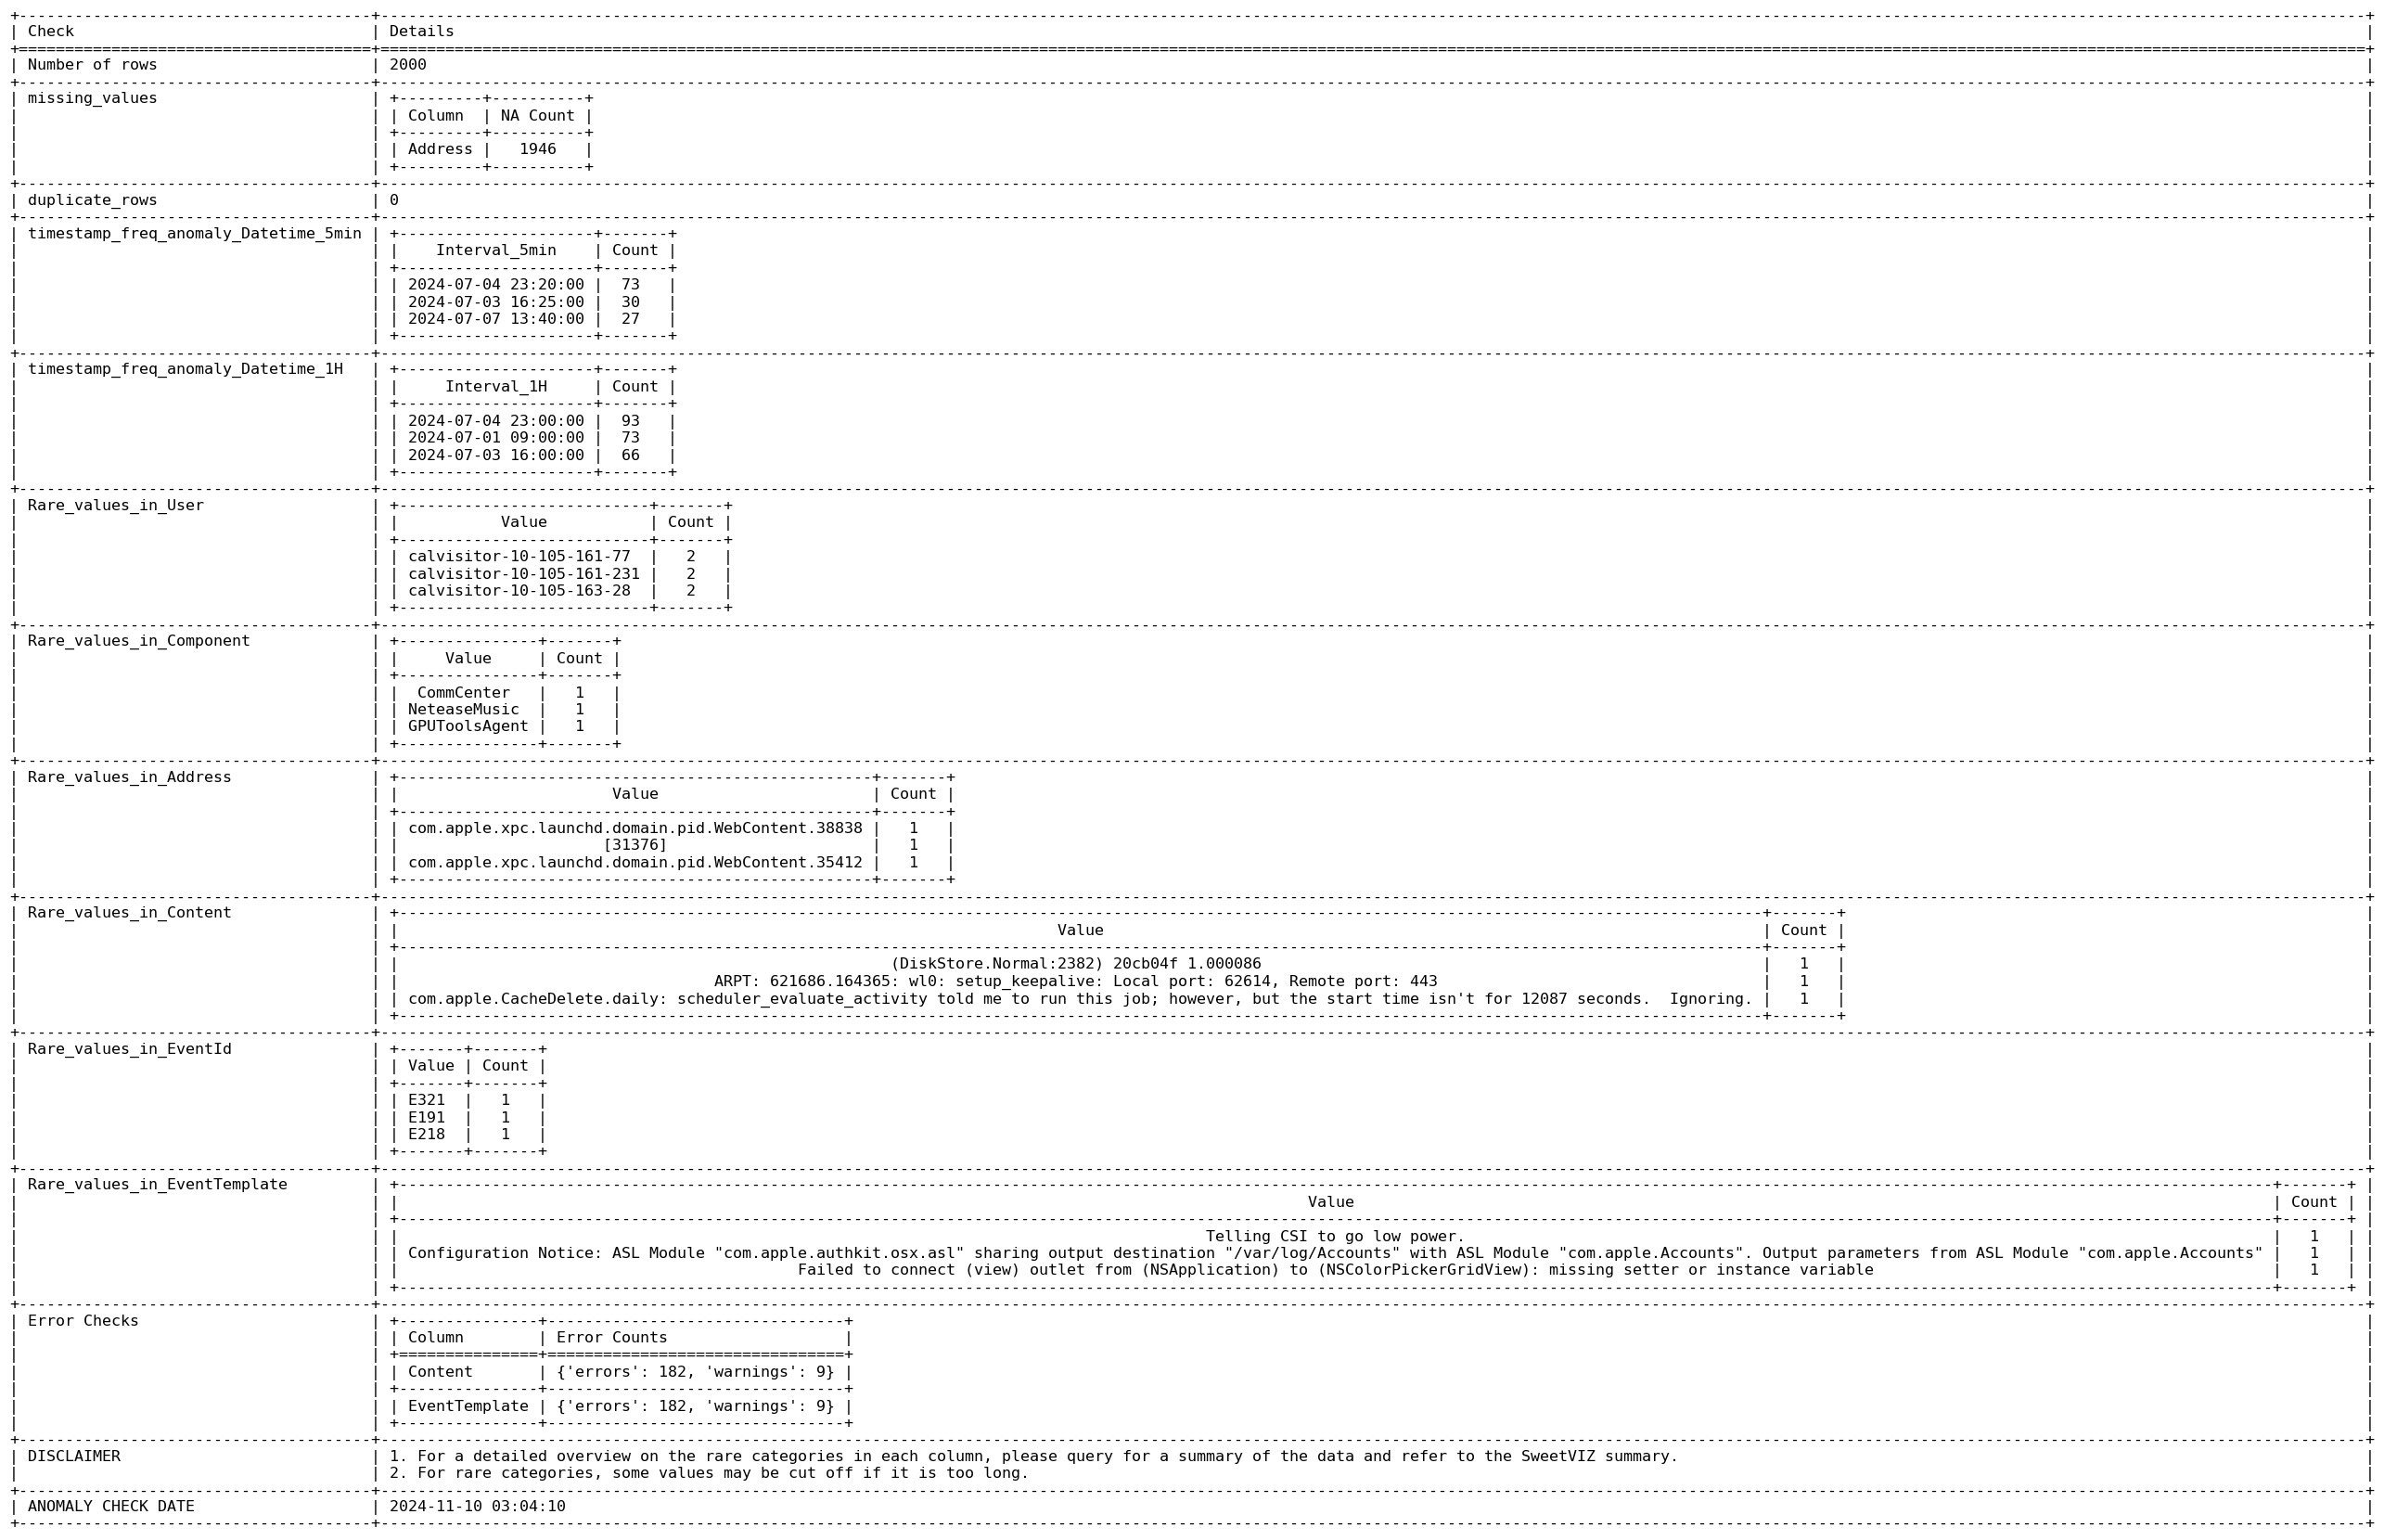

In [93]:
overall_anomaly(data)

In [ ]:
# df = data[['Datetime']]
# df.set_index('Datetime', inplace=True)
# count_by_interval = df.groupby(pd.Grouper(freq='H')).size()
# intervals_list = list(count_by_interval.index)

# for x in range(len(intervals_list)):

intervals = data.resample('1h', on='Datetime').size()

# resampled_data = pd.DataFrame({'Count': 0}, index=intervals)
# #print(intervals)

# def interval_finder(intervals, t):
#     if len(intervals) < 2:
#         return intervals[0]
#     for x in range(len(intervals)-1):
#         start = intervals[x]
#         end = intervals[x+1]
#         if start <= t <= end:
#             return start
#     return end

# for t in data['Datetime']:
#     interval_group = interval_finder(intervals, t)
#     print(t, interval_group)
intervals
    

In [ ]:
from scipy import stats
from copy import deepcopy

def timing_resampler(df, interval, column):
        """
        Resamples time series data at specified intervals.

        Function Description:
        Groups data by time intervals and calculates statistical measures (skewness, kurtosis)
        to identify unusual patterns in temporal distribution.

        Input:
        - df (pd.DataFrame): DataFrame containing timestamp data
        - interval (str): Time interval for resampling (e.g., '1min', '1H')
        - column (str): Name of timestamp column

        Output:
        - tuple: Contains:
            - interval_df: Resampled DataFrame
            - skew: Skewness measure
            - kurt: Kurtosis measure
            - total: Combined statistical measure

        Note:
        - Returns empty DataFrame if resampling fails
        - Requires datetime-formatted column
        """
        data_copy = deepcopy(df)
        interval_counts = data_copy.resample(interval, on=column).size()
        interval_df = pd.DataFrame(interval_counts).reset_index()
        res = stats.shapiro(interval_df[0])
        return (interval_df, res.statistic, res.pvalue)

intervals = ['1min', '5min', '10min', '30min', '1H', '2H', '3H', '6H', '12H', '1D', '3D', '5D']
res = []
for i in intervals:
    try:
        data_resampled, stat, p = timing_resampler(data, i , 'Datetime')
        if len(data) == 0:
            pass
        res.append((i, data_resampled, stat, p))
    except Exception as err:
        print(err)

Data must be at least length 3.


c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
res

[INFO] Anomaly Skill called
[INFO] Anomaly Skill: missing values checked
[INFO] Anomaly Skill: duplicate rows checked
[INFO] Anomaly Skill: numerical outliers checked
[INFO] Anomaly Skill: timestamp checked
[INFO] Anomaly Skill: categorical columns checked


C:\Users\Wang Xing Yu\AppData\Local\Temp\ipykernel_12080\2891232265.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rarest['Value'] = rarest['Value'].apply(lambda x: x[:200])
C:\Users\Wang Xing Yu\AppData\Local\Temp\ipykernel_12080\2891232265.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rarest['Value'] = rarest['Value'].apply(lambda x: x[:200])
C:\Users\Wang Xing Yu\AppData\Local\Temp\ipykernel_12080\2891232265.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

'tabulated_anomalies.png'

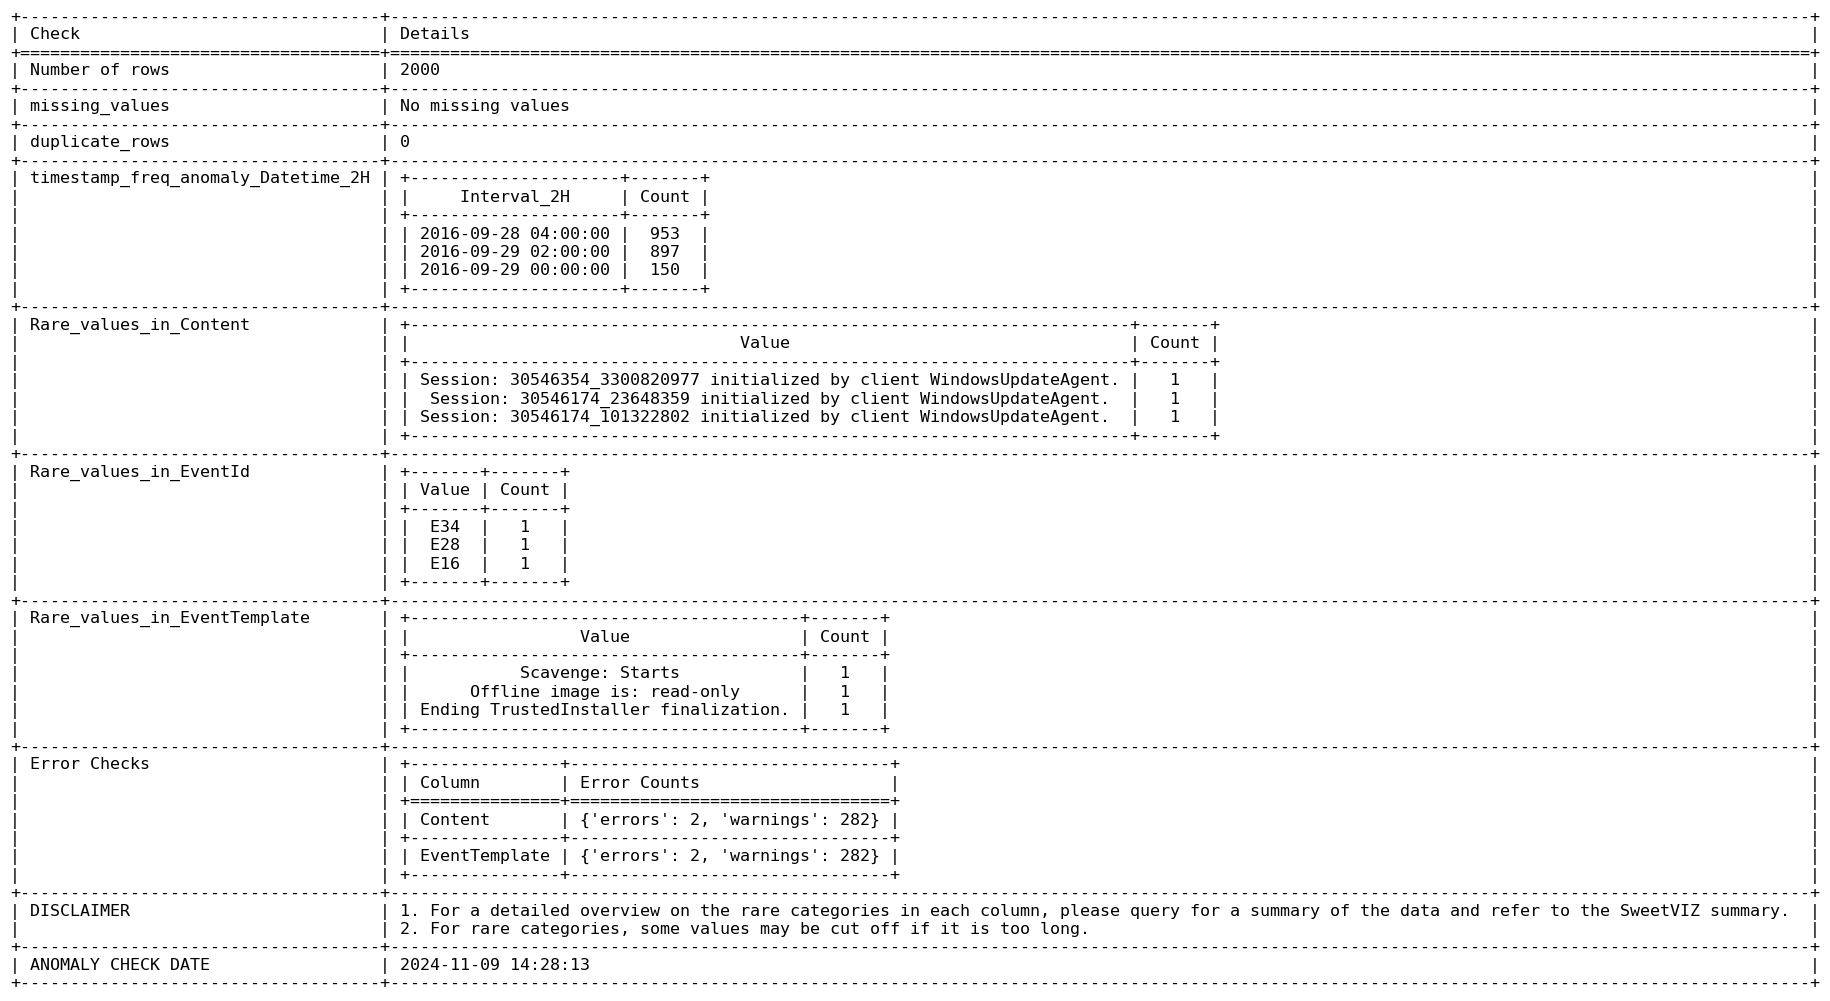

In [7]:
anomaly_skill(data)

In [45]:
import numpy as np

np.corrcoef(list(range(len(data['ResultCount'].dropna()))), data['ResultCount'].dropna().sort_values())

array([[1.        , 0.72754543],
       [0.72754543, 1.        ]])

In [22]:
def timing_resampler(df, interval, column):
    interval_counts = df.resample(interval, on=column).size()
    interval_df = pd.DataFrame(interval_counts).reset_index()
    interval_df.columns = [f'Interval_{interval}', 'Count']
    skew = interval_df['Count'].skew()
    kurt = interval_df['Count'].kurt()
    return (interval_df, skew, kurt, skew+ np.abs(kurt-3))

def timing_outliers(interval_df):
    q1 = interval_df['Count'].quantile(0.25)
    q3 = interval_df['Count'].quantile(0.75)
    iqr = q3-q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered_df = interval_df[(interval_df['Count'] > upper) | (interval_df['Count'] < lower)].reset_index(drop=True)
    return filtered_df

def best_timing(df):
    intervals = ['1min', '5min', '10min', '30min', '1H', '2H', '3H', '6H', '12H', '1D']
    res = []
    for i in intervals:
        data, skew, kurt, total = timing_resampler(df, i , 'Datetime')
        if len(data) == 0:
            pass
        res.append((i, data, skew, kurt, total))

    if len(res) == 0:
        return pd.DataFrame()

    res.sort(key=lambda x:x[-1])
    best_interval = res[0][0]
    best_df = timing_outliers(res[0][1])
    return best_interval, best_df


    
best_timing(df_mac)
#timing_helper(df_mac, '3H', 'Datetime')

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4))  
ax.axis('off')  
plt.text(0.5, 0.5, mac_table, family='monospace', ha='center', va='center', fontsize=12)


png_path = "tabulated_anomalies.png"
plt.savefig(png_path, bbox_inches='tight', dpi=300)

In [ ]:
from pprint import pprint

df_credit_card = pd.read_csv('../../../logs/Credit card transactions - India - Simple.csv')
pprint(anomaly_skill(df_credit_card))